### Develop a structure of the new annotation file

    dict structure
    * ds_name [VOC2012, COCO]
    * subset [name like train2017/val2017 for COCO, train/test/valid, etc.]
    * subset_dir_fp [full path to the directory with images from this subset, e.g. ../train2017 for COCO,
    ../VOC2012/JPEGImages for VOC2012]
    * subset_isegmaps_dir_fp [../VOC2012/SegmentationClass for the VOC2012]
    * imgs
        * hs [heights, required for COCO]
        * ws [widths, required for COCO]
        * imgs_sps [list of image short paths, os.path.join(subset_dir_fp, img_sp) has to give a valid full path to the image ]
        * isegmaps_sps [short paths to the instance segmenation map image, e.g. VOC2012, so that
        os.path.join(subset_isegmaps_dir_fp, isegmap_sp) has to give a valid full path to the instance segmenation map]
        * insts [list of lists of instances corresponding to images in the img_sp], one list entry:
            - bboxes list  [bounding box of the instance, in float for COCO and int for VOC2012]
            - labels list [label of the instance, netural categories in COCO naming order for COCO and VOC]
            - colors list [color for MNISTISEG/OMNIISEG/VOC2012]
            - segmentation maps info list [RLE for COCO, e.g.]


In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from cp_dir_file_ops import *
from datasets.coco.create_annotation_coco import *

In [2]:
if 'data_val' not in locals():
    subset = 'val2017'
    new_file_sp = os.path.join('datasets', 'coco', 'resources', f'new_{subset}.json')
    new_file_fp = os.path.join(get_project_path(), new_file_sp)
    data_val = read_json(new_file_fp)
    print('Read first time')
else:
    print('Already initialized')

Read first time


### Select a random image and draw it with bounding boxes and annotation masks

Choosing a random image from  5000 variants
Chose 4773
Finished


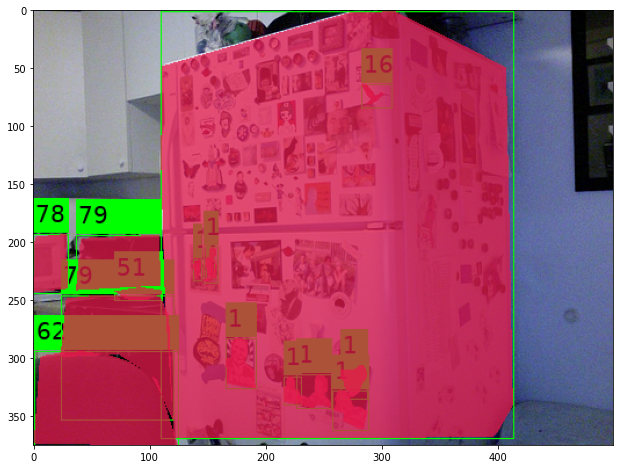

In [7]:
def get_random_img_ann_info(data):
    print('Choosing a random image from ',
          len(data['imgs']['insts']), 'variants')
    idx = np.random.randint(len(data['imgs']['insts']))
    print('Chose', idx)

    img_sp = data['imgs']['imgs_sps'][idx]
    subset_dir_fp = data['subset_dir_fp']
    img_fp = os.path.join(subset_dir_fp, img_sp)
    img = plt.imread(img_fp)

    h = data['imgs']['hs'][idx]
    w = data['imgs']['ws'][idx]
    insts = data['imgs']['insts'][idx]

    bboxes_all = []
    cat_ids_all = []
    isegmaps_all = []
    for i in range(len(insts)):
        bbox = insts[i][0]
        bboxes_all.append(bbox)
        del bbox
        cat_id = insts[i][1]
        cat_ids_all.append(cat_id)
        del cat_id
        ann_segmentation = insts[i][2]
        isegmap = get_mask_for_coco_img_inst(img_h=h, img_w=w,
                                             ann_segmentation=ann_segmentation)
        isegmaps_all.append(isegmap)
        if isegmap.min() == 0 and isegmap.max() == 0:
            print('Bad mask, IDX', idx)
            assert False
        del isegmap

    print('Finished')
    return img, bboxes_all, cat_ids_all, isegmaps_all


# img, bboxes_all, cat_ids_all, isegmaps_all = get_random_img_ann_info(data_val)
# _ = show_annotations_on_img(img, bboxes_all, cat_ids_all, isegmaps_all, show=True)

### Check if it is real to decode all the instance segmentation masks with a simplified method

In [4]:
def check_annotation_algo(data):
    insts = data['imgs']['insts']
    for i in range(len(insts)):
        for j in range(len(insts[i])):
            bbox = insts[i][j][0]
            cat_id = insts[i][j][1]
            ann_segmentation = insts[i][j][2]
            if not isinstance(ann_segmentation, list):
                print('Bounding boxes', bbox)
                print('Categories IDS', cat_id)
                print('Annotation type is:', type(ann_segmentation))
                if isinstance(ann_segmentation, dict):
                    print('-> keys:', ann_segmentation.keys())
                else:
                    print('-> data:', ann_segmentation)
                print('Whole COCO decoding algorithm is required!')
                return

    print('Finished')

# check_annotation_algo(data_val)
# check_annotation_algo(data_train)

### Check images with objects which have almost an empty mask

In [5]:
def check_annotation_algo(data):
    hs = data['imgs']['hs']
    ws = data['imgs']['ws']
    insts = data['imgs']['insts']
    for i in tqdm(range(len(insts)), total=len(insts)):
        img_h = hs[i]
        img_w = ws[i]
        for j in range(len(insts[i])):
            bbox = insts[i][j][0]
            cat_id = insts[i][j][1]
            ann_segmentation = insts[i][j][2]
            mask = get_mask_for_coco_img_inst(img_h, img_w, ann_segmentation)
            if mask.min() == 0 and mask.max() == 0:
                print('Found an empty mask')
                print('Bounding boxes', bbox)
                print('Categories IDS', cat_id)
                print('Annotation:', type(ann_segmentation))
                plt.imshow(mask, cmap='gray')
                plt.show()
                return

    print('Finished, all masks are not empty and contain a segmented object')

check_annotation_algo(data_val)
# check_annotation_algo(data_train)


100%|██████████| 5000/5000 [00:47<00:00, 105.20it/s]


Finished, all masks are not empty and contain a segmented object


### Find out if a segmentation mask could be outside of a bbox

  0%|          | 0/5000 [00:00<?, ?it/s]


Case X1
Bbox and mask are not the same borders
Image shape 427 640
240.54 217.62 298.28999999999996 256.61
241 218 297 256


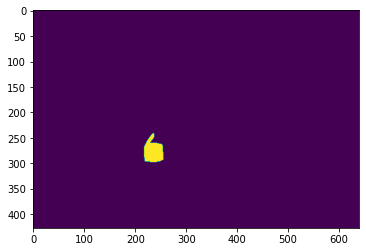

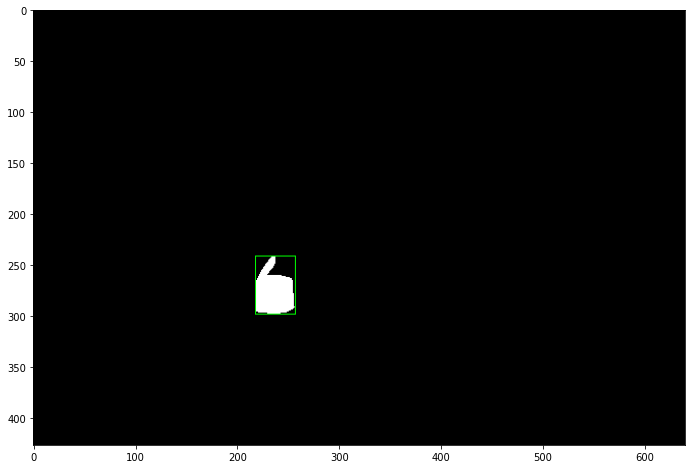

AssertionError: 

In [6]:
def check_isegmaps_if_in_bboxes(data):
    hs = data['imgs']['hs']
    ws = data['imgs']['ws']
    insts = data['imgs']['insts']
    for i in tqdm(range(len(insts)), total=len(insts)):
        img_h = hs[i]
        img_w = ws[i]
        for j in range(len(insts[i])):
            bbox = insts[i][j][0]
            y1, x1, y2, x2 = bbox
            ann_segmentation = insts[i][j][2]
            mask = get_mask_for_coco_img_inst(img_h, img_w, ann_segmentation)
            if mask.min() == 0 and mask.max() == 0:
                print('Mask is totally black')
                assert False
            #
            ymin_line = np.max(mask, axis=1)
            indices_y = np.where(ymin_line == 1)[0]
            ymin, ymax = indices_y[0], indices_y[-1]
            #
            xmin_line = np.max(mask, axis=0)
            indices_x = np.where(xmin_line == 1)[0]
            xmin, xmax = indices_x[0], indices_x[-1]
            #
            if xmin != x1 or xmax != x2 or ymin != y1 or ymax != y2:
                if xmin != x1:
                    print('Case X1')
                elif xmax != x2:
                    print('Case X2')
                elif ymin != y1:
                    print('Case Y1')
                elif ymax != y2:
                    print('Case Y2')
                print('Bbox and mask are not the same borders')
                print('Image shape', img_h, img_w)
                print(y1, x1, y2, x2)
                print(ymin, xmin, ymax, xmax)
                plt.imshow(mask * 255)
                plt.show()

                mask = np.dstack([mask, mask, mask]) * 255
                show_annotations_on_img(mask, [bbox], cat_ids=None, isegmaps=None, show=True)
                assert False

        print('All segmentation maps are in a corresponding bbox')
        return

check_isegmaps_if_in_bboxes(data_val)

Conclusions:

- COCO stores its bbox annotations in x, y, width, height format
- COCO instance segmentation masks are not 100% precise
because it seems to be an unreachable limit
- imgaug has different set of classes to work with bounding boxes and segmentation masks
- borders of an instance segmentation map of an arbitrary object may
not fit into a bounding box, coordinated may be larger or smaller
- in order to understand if it a problem, check Mask R-CNN masks sampling technique
- rle decoder produces a mask with 0 and 1 values